# Определение возраста покупателей

Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:

    Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
    Контролировать добросовестность кассиров при продаже алкоголя.

Предлагается построить модель, которая по фотографии определит приблизительный возраст человека. В нашем распоряжении набор фотографий людей с указанием возраста.

## Исследовательский анализ данных

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

PATH = '/datasets/faces/'

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


None

(7591, 2)

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


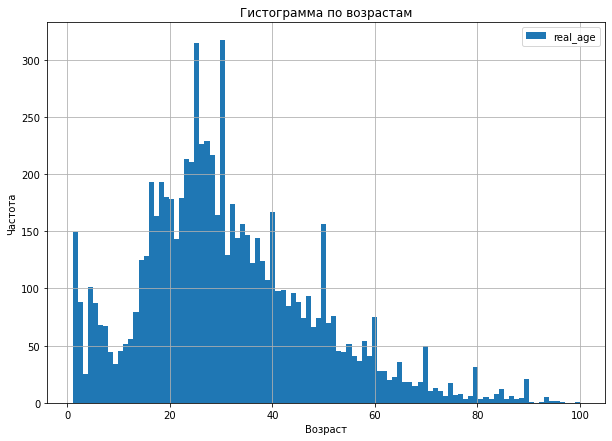

In [2]:
labels = pd.read_csv(PATH+'labels.csv')

display(labels.describe())
display(labels.info())
display(labels.shape)
display(labels.head())

labels.plot(kind='hist', bins=100,
            grid=True,
            figsize=(10, 7),
            title='Гистограмма по возрастам')
plt.ylabel('Частота')
plt.xlabel('Возраст')
plt.show()

In [3]:
train_datagen = ImageDataGenerator(
    validation_split=0.25,
    rescale=1./255)

train_datagen_flow = train_datagen.flow_from_dataframe(
    labels,
    PATH+'final_files',
    x_col='file_name',
    y_col='real_age',
    class_mode='raw',
    target_size=(224, 224),
    batch_size=16,
    subset='training',
    seed=12345)

Found 5694 validated image filenames.


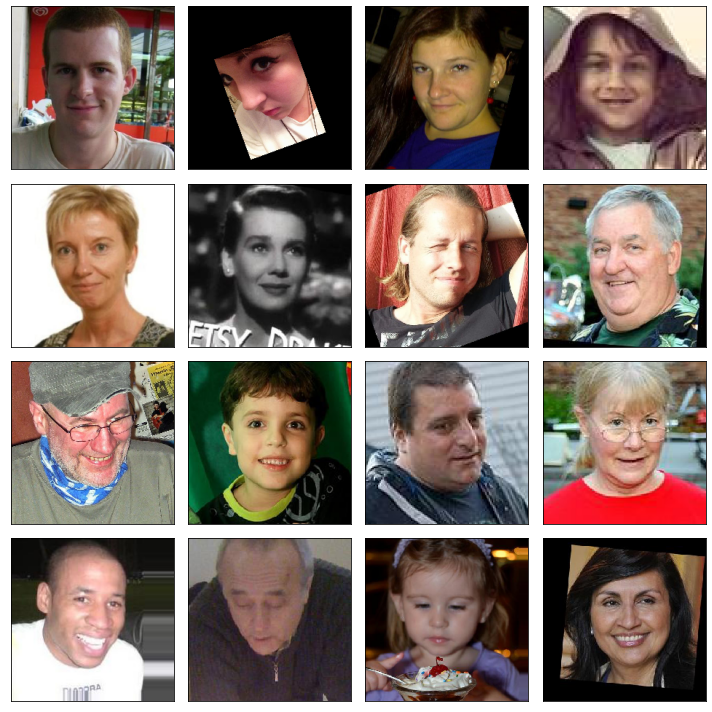

In [4]:
features, target = next(train_datagen_flow)
fig = plt.figure(figsize=(10,10))
for i in range(16):
    fig.add_subplot(4, 4, i+1)
    plt.imshow(features[i])
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

In [5]:
def shape_viewer(path):
    img = Image.open(PATH+'final_files/'+path)
    return np.array(img).shape

labels['shape'] = labels.file_name.apply(shape_viewer)
labels['width'] = labels['shape'].apply(lambda x: x[0])
labels['length'] = labels['shape'].apply(lambda x: x[1])
labels['depth'] = labels['shape'].apply(lambda x: x[2])

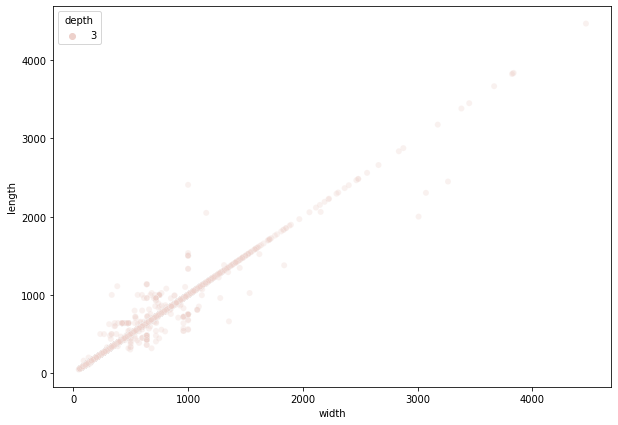

In [6]:
plt.figure(figsize=(10, 7))
sns.scatterplot(x=labels['width'],
                y=labels['length'],
                hue=labels['depth'],
                alpha=0.3)
plt.show()

Согласно частичной выгрузке и графику мы можем отметить следующие особенности датасета:
* у нас только трехканальные изображения;
* размер изображений колеблется от очень малых (< 200 пикселей на измерение) до очень больших (> 4000 пикселей на измерение);
* изображения преимущественно квадратные, но также имеются и прямоугольные (облако в области 700 пикселей по вертикали и горизонтали);
* изображения в правильной ориентации, поэтому стоит рассмотреть тренировочную выгрузку только с горизонтальным флипом и угловыми искажениями.

## Обучение модели

Перенесите сюда код обучения модели и её результат вывода на экран.


(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

```python
import numpy as np
import pandas as pd

from tensorflow.keras.layers import Conv2D, Flatten, Dense, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.resnet import ResNet50

def load_train(path):
    
    labels = pd.read_csv(path+'labels.csv')
    
    train_datagen = ImageDataGenerator(
        validation_split=0.25,
        rescale=1./255,
        horizontal_flip=True,
        # vertical_flip=True,
        # rotation_range=90,
        width_shift_range=0.20,
        height_shift_range=0.20
    )

    train_datagen_flow = train_datagen.flow_from_dataframe(
        labels,
        path+'final_files',
        x_col='file_name',
        y_col='real_age',
        class_mode='raw',
        target_size=(224, 224),
        batch_size=16,
        subset='training',
        seed=12345)
    
    return train_datagen_flow

def load_test(path):
    
    labels = pd.read_csv(path+'labels.csv')
    
    test_datagen = ImageDataGenerator(
        validation_split=0.25,
        rescale=1./255)
    
    test_datagen_flow = test_datagen.flow_from_dataframe(
        labels,
        path+'final_files',
        x_col='file_name',
        y_col='real_age',
        class_mode='raw',
        target_size=(224, 224),
        batch_size=16,
        subset='validation',
        seed=12345)
    
    return test_datagen_flow

def create_model(input_shape):

    backbone = ResNet50(input_shape=input_shape,
                        weights='/datasets/keras_models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5',
                        # weights='imagenet',
                        include_top=False)

    # замораживаем ResNet50 без верхушки
    # backbone.trainable = False

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(512, activation='relu'))
    model.add(Dense(1, activation='relu'))
    
    optimizer = Adam(lr=0.0007) #0.0005
    model.compile(optimizer=optimizer, loss='mean_squared_error',
                  metrics=['mean_absolute_error'])

    return model

def train_model(model, train_data, test_data, batch_size=None, epochs=20,
               steps_per_epoch=None, validation_steps=None):

    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size,
              epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2, shuffle=True)

    return model

```

Found 5694 validated image filenames.

Found 1897 validated image filenames.

Epoch 1/20

356/356 - 107s - loss: 268.4311 - mean_absolute_error: 12.5506 - val_loss: 288.0795 - val_mean_absolute_error: 13.5022

Epoch 2/20

356/356 - 100s - loss: 202.5146 - mean_absolute_error: 10.9901 - val_loss: 405.8451 - val_mean_absolute_error: 16.7389

Epoch 3/20

356/356 - 100s - loss: 174.0203 - mean_absolute_error: 10.2243 - val_loss: 156.1976 - val_mean_absolute_error: 9.9179

Epoch 4/20

356/356 - 100s - loss: 158.3901 - mean_absolute_error: 9.6481 - val_loss: 262.7600 - val_mean_absolute_error: 11.8361

Epoch 5/20

356/356 - 100s - loss: 143.0834 - mean_absolute_error: 9.1195 - val_loss: 226.8377 - val_mean_absolute_error: 11.0825

Epoch 6/20

356/356 - 99s - loss: 139.6642 - mean_absolute_error: 9.0573 - val_loss: 156.6355 - val_mean_absolute_error: 9.3856

Epoch 7/20

356/356 - 100s - loss: 134.6024 - mean_absolute_error: 8.8737 - val_loss: 148.6494 - val_mean_absolute_error: 9.1229

Epoch 8/20

356/356 - 100s - loss: 127.7621 - mean_absolute_error: 8.7017 - val_loss: 170.3935 - val_mean_absolute_error: 10.3090

Epoch 9/20

356/356 - 100s - loss: 122.3571 - mean_absolute_error: 8.4423 - val_loss: 130.4083 - val_mean_absolute_error: 8.5374

Epoch 10/20

356/356 - 101s - loss: 114.5473 - mean_absolute_error: 8.1884 - val_loss: 152.0372 - val_mean_absolute_error: 8.9980

Epoch 11/20

356/356 - 100s - loss: 109.2427 - mean_absolute_error: 7.9868 - val_loss: 162.7684 - val_mean_absolute_error: 10.0690

Epoch 12/20

356/356 - 101s - loss: 107.5977 - mean_absolute_error: 7.8720 - val_loss: 174.8849 - val_mean_absolute_error: 9.8095

Epoch 13/20

356/356 - 104s - loss: 99.1943 - mean_absolute_error: 7.5565 - val_loss: 170.3482 - val_mean_absolute_error: 9.6480

Epoch 14/20

356/356 - 104s - loss: 96.2601 - mean_absolute_error: 7.4024 - val_loss: 91.1018 - val_mean_absolute_error: 7.3325

Epoch 15/20

356/356 - 104s - loss: 93.1557 - mean_absolute_error: 7.3777 - val_loss: 146.1273 - val_mean_absolute_error: 9.3515

Epoch 16/20

356/356 - 106s - loss: 88.6623 - mean_absolute_error: 7.1351 - val_loss: 113.7801 - val_mean_absolute_error: 8.1911

Epoch 17/20

356/356 - 107s - loss: 86.2048 - mean_absolute_error: 7.0935 - val_loss: 244.0719 - val_mean_absolute_error: 11.6419

Epoch 18/20

356/356 - 108s - loss: 78.5963 - mean_absolute_error: 6.7368 - val_loss: 166.5925 - val_mean_absolute_error: 9.4647

Epoch 19/20

356/356 - 107s - loss: 84.4391 - mean_absolute_error: 6.9739 - val_loss: 99.5356 - val_mean_absolute_error: 7.2747

Epoch 20/20

356/356 - 106s - loss: 75.0612 - mean_absolute_error: 6.5719 - val_loss: 96.0310 - val_mean_absolute_error: 7.3005

## Анализ обученной модели

Модель достигла заданного значения метрики MAE на тестовой выборке (< 8) по итогам 20 эпох. Как мы можем заметить значения функции потерь (mse) и метрики (mae) на обучающей выборке снижались достаточно монотонно без большого разброса. Однако те же самые параметры на тренировочной выборке имеют куда более значительный разброс - что делает предсказания модели менее стабильными. Поэтому, полагаю, в качестве дальнейшей работы стоит рассмотреть возможность добавить методы стабилизации предсказаний, например, дропауты и нормализаторы.